# Produce lifetime XY map

## Run 5808:  
-June 8th, buggy DAQ configuration resulting in bad S1s

### Notebook configuration

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [122]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStat

In [9]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf

In [10]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d

### Files

In [6]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
run_number          = 5808
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}_s1s2.h5"
output_dst_filename = f"{path}/{run_number}/kdst_{run_number}_ltmap.h5"

print(f"run number = {run_number}")
print(f"input dst = {input_dst_filename}")
print(f"output dst = {output_dst_filename}")

run number = 5808
input dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5808/kdst_5808_s1s2.h5
output dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5808/kdst_5808_ltmap.h5


### Ranges and binning

In [94]:
Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   30
Enbins  =  100
Qnbins  =  100

Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

In [95]:
krNBins  = KrNBins(E = Enbins, Q = Qnbins, Z = Znbins, XY = XYnbins)
krRanges = KrRanges(E = Erange, Q = Qrange, Z = Zrange, XY = XYrange)
krBins   = KrBins(E = Ebins, Q = Qbins, Z = Zbins, XY = XYbins, cXY = XYcenters) 

### Read data

In [96]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 109604 
Total number of events: 109604


In [14]:
dst.head()

,index,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,0,1,1.528475e+09,0,0,1,1,150.0,4.019929,18.183367,...,26,150.888750,150.888750,1.311636,139.701305,26.701700,142.230220,0.188856,9.300186,11.253162
1,4,3,1.528475e+09,0,0,1,1,250.0,1.003306,6.553847,...,17,73.036125,73.036125,0.894585,92.468140,51.582643,105.882604,0.508844,8.225369,8.245760
2,14,11,1.528475e+09,0,0,1,1,150.0,1.405130,7.993404,...,16,185.775250,185.775250,1.404683,135.578076,113.614583,176.888915,0.697487,9.240626,7.974480
3,15,12,1.528475e+09,0,0,1,1,125.0,1.647384,6.420486,...,12,217.182187,217.182187,1.631511,155.461857,-115.508213,193.676370,-0.639006,7.543103,8.758780
4,18,14,1.528475e+09,0,0,1,1,150.0,0.668689,4.146299,...,17,168.897375,168.897375,1.366862,102.510763,61.543521,119.566139,0.540685,14.270317,17.482493


In [97]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

krEvent = KrEvent(X = dst.X.values,
                  Y = dst.Y.values,
                  Z = dst.Z.values,
                  E = dst.S2e.values,
                  Q = dst.S2q.values)

### Event distribution

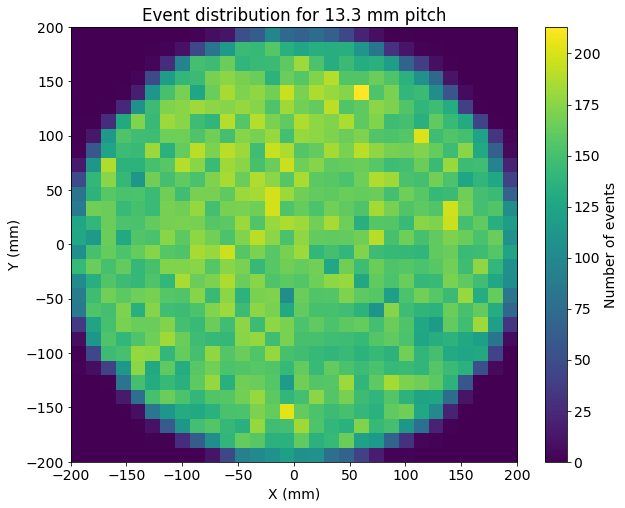

In [98]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

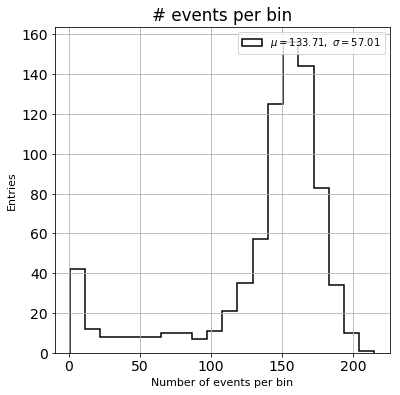

In [99]:
nevt_max = int(np.max(nevt))
mu, sigma = krh.h1d(nevt.flatten(), bins=20, range=(1, nevt_max + 2),
        xlabel='Number of events per bin', ylabel='Entries',
        title="# events per bin", legend = 'upper right',)

### Fit examples

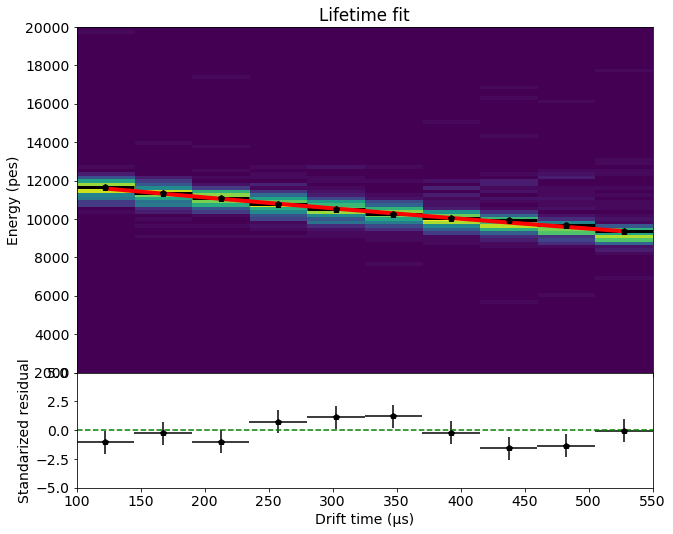

In [100]:
xlim =  -25,  25
ylim = -25, 25
xyr = XYRanges(X=xlim, Y=ylim )

kf = krf.lifetime_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr)

In [101]:
krf.print_fit(kf)

 E (z=0) = 12362.533860189245 +-59.951940884972515 
 LT      = -1897.8184554433717 +-55.8567841784539 
 chi2    = 1.0789356766806144 


### Compute lifetime maps

In [102]:
krfs = krf.fit_slices_2d_expo(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=1e2)

/Users/jjgomezcadenas/Projects/ICARO/icaro/core/fit_functions.py:85: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0


In [103]:
Escale_abs, ELT_abs, Echi2, Eok = krfs.Ez0, krfs.LT, krfs.chi2, krfs.valid   

In [104]:
krfs = krf.fit_slices_2d_expo(krEvent, krNBins, krBins, krRanges, fit_var = "Q", min_entries=1e2)

/Users/jjgomezcadenas/Projects/ICARO/icaro/core/fit_functions.py:85: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0


In [105]:
Qscale_abs, QLT_abs, Qchi2, Qok = krfs.Ez0, krfs.LT, krfs.chi2, krfs.valid 

In [116]:
#Escale_abs, ELT_abs, Echi2, Eok = krf.fit_slices_2d_expo(X, Y, Z, E, 
#                                                         XYbins, XYbins, Znbins, 
#                                                         zrange=Zrange, min_entries=1e2)
Eok        = ELT_abs.value > 100
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [117]:
#Qscale_abs, QLT_abs,\
#Qchi2, Qok = krf.fit_slices_2d_expo(X, Y, Z, Q, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=1e2)
Qok        = QLT_abs.value > 100
Qscale     = to_relative(Qscale_abs, percentual=True)
QLT        = to_relative(   QLT_abs, percentual=True)

In [123]:
El = KrMeanAndStat(mu    = np.nanmean(ELT   .value      [Eok]),
                   std   = np.nanstd (ELT   .value      [Eok]),
                   mu_u  = np.nanmean(ELT   .uncertainty[Eok]),
                   std_u = np.nanstd (ELT   .uncertainty[Eok]))
Es = KrMeanAndStat(mu   = np.nanmean(Escale   .value      [Eok]),
                   std   = np.nanstd (Escale   .value      [Eok]),
                   mu_u  = np.nanmean(Escale   .uncertainty[Eok]),
                   std_u = np.nanstd (Escale   .uncertainty[Eok]))
Ql = KrMeanAndStat(mu    = np.nanmean(QLT   .value      [Eok]),
                   std   = np.nanstd (QLT   .value      [Eok]),
                   mu_u  = np.nanmean(QLT   .uncertainty[Eok]),
                   std_u = np.nanstd (QLT   .uncertainty[Eok]))
Qs = KrMeanAndStat(mu    = np.nanmean(Qscale   .value      [Eok]),
                   std   = np.nanstd (Qscale   .value      [Eok]),
                   mu_u  = np.nanmean(Qscale   .uncertainty[Eok]),
                   std_u = np.nanstd (Qscale   .uncertainty[Eok]))

In [128]:
print(f" Lifetime measured in energy plane ={El}")
print(f" Energy scale in energy plane ={Es}")
print(f" Lifetime measured in tracking plane ={Ql}")
print(f" Energy scale in tracking plane ={Qs}")

 Lifetime measured in energy plane =KrMeanAndStat(mu=1583.4656651082928, std=332.09643058517543, mu_u=7.1401605902287866, std_u=5.5144018698284683)
 Energy scale in energy plane =KrMeanAndStat(mu=10637.552855931139, std=1399.2778731704229, mu_u=1.4103211545083509, std_u=0.93231247784931826)
 Lifetime measured in tracking plane =KrMeanAndStat(mu=-506921081.42691779, std=5523525118.1670876, mu_u=7514712.1076287376, std_u=149982834.16118222)
 Energy scale in tracking plane =KrMeanAndStat(mu=527.90728757413626, std=51.412677281719866, mu_u=2.8370250615584296, std_u=0.83654897663069816)


In [15]:
ELT_mean  = np.nanmean(ELT   .value      [Eok])
ELT_std   = np.nanstd (ELT   .value      [Eok])
ELTu_mean = np.nanmean(ELT   .uncertainty[Eok])
ELTu_std  = np.nanstd (ELT   .uncertainty[Eok])

E_mean    = np.nanmean(Escale.value      [Eok])
E_std     = np.nanstd (Escale.value      [Eok])
Eu_mean   = np.nanmean(Escale.uncertainty[Eok])
Eu_std    = np.nanstd (Escale.uncertainty[Eok])

QLT_mean  = np.nanmean(QLT   .value      [Qok])
QLT_std   = np.nanstd (QLT   .value      [Qok])
QLTu_mean = np.nanmean(QLT   .uncertainty[Qok])
QLTu_std  = np.nanstd (QLT   .uncertainty[Qok])

Q_mean    = np.nanmean(Qscale.value      [Qok])
Q_std     = np.nanstd (Qscale.value      [Qok])
Qu_mean   = np.nanmean(Qscale.uncertainty[Qok])
Qu_std    = np.nanstd (Qscale.uncertainty[Qok])

In [129]:
n_sigma  = 3
u_sigma  = 2
E_min    = Es.mu - n_sigma * Es.std
E_max    = Es.mu + n_sigma * Es.std

print(f" Energy scale (E): E_min = {E_min}; E_max = {E_max}")

ELT_min  = El.mu - n_sigma * El.std
ELT_max  = El.mu + n_sigma * El.std

print(f" Lifetime (ELT): ELT_min = {ELT_min}; ELT_max = {ELT_max}")

Eu_min   = max(Es.mu_u - u_sigma * Es.std_u, 1e-3)
Eu_max   =     Es.mu_u + u_sigma * Es.std_u

print(f" Energy scale error (Eu): Eu_min = {Eu_min}; Eu_max = {Eu_max}")

ELTu_min = max(El.mu_u - u_sigma * El.std_u, 1e-3)
ELTu_max =     El.mu_u + u_sigma * El.std_u

print(f" Lifetime error (ELTu): ELTu_min = {ELTu_min}; ELTu_max = {ELTu_max}")

Q_min    = Qs.mu - n_sigma * Qs.std
Q_max    = Qs.mu + n_sigma * Qs.std

print(f" Energy scale (Q): Q_min = {Q_min}; Q_max = {Q_max}")

QLT_min  = Ql.mu - n_sigma * Ql.std
QLT_max  = Ql.mu + n_sigma * Ql.std

print(f" Lifetime (QLT): QLT_min = {QLT_min}; QLT_max = {QLT_max}")

Qu_min   = max(Qs.mu_u - u_sigma * Qs.std_u, 1e-3)
Qu_max   =     Qs.mu_u + u_sigma * Qs.std_u

print(f" Energy scale error (Qu): Qu_min = {Qu_min}; Qu_max = {Qu_max}")

QLTu_min = max(Ql.mu_u - u_sigma * Ql.std_u, 1e-3)
QLTu_max =     Ql.mu_u + u_sigma * Ql.std_u

print(f" Lifetime error (QLTu): QLTu_min = {QLTu_min}; QLTu_max = {QLTu_max}")


 Energy scale (E): E_min = 6439.71923641987; E_max = 14835.386475442407
 Lifetime (ELT): ELT_min = 587.1763733527665; ELT_max = 2579.754956863819
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 3.2749461102069874
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 18.168964329885725
 Energy scale (Q): Q_min = 373.6692557289767; Q_max = 682.1453194192959
 Lifetime (QLT): QLT_min = -17077496435.92818; QLT_max = 16063654273.074345
 Energy scale error (Qu): Qu_min = 1.1639271082970333; Qu_max = 4.5101230148198255
 Lifetime error (QLTu): QLTu_min = 0.001; QLTu_max = 307480380.4299932


### Map display

In [132]:
x1 = loc_elem_1d(ELT.value[Eok].flatten(), krc.find_nearest(ELT.value[Eok].flatten(),ELT_min))
x2 = loc_elem_1d(ELT.value[Eok].flatten(), krc.find_nearest(ELT.value[Eok].flatten(),ELT_max))
xmin = min(x1, x2)
xmax = max(x1, x2)
print(xmin, xmax)
h = ELT.value[Eok].flatten()
print(f"average lifetime = {np.average(h[xmin:xmax])}")

416 583
average lifetime = 1588.2021533522056


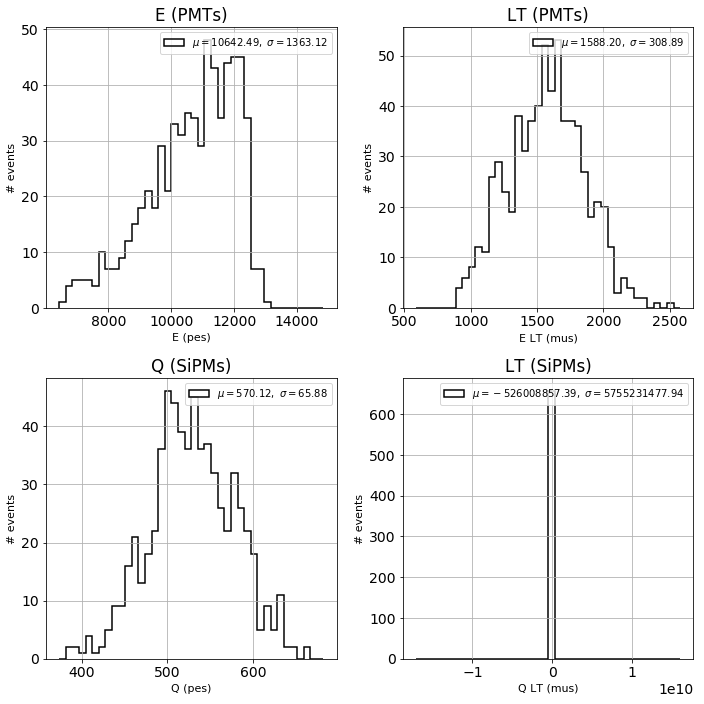

In [133]:
krh.h1d_4(h1ds    = (Escale.value[Eok].flatten(), 
                     ELT.value[Eok].flatten(), 
                     Qscale.value[Eok].flatten(), 
                     QLT.value[Eok].flatten()),
      bins    = (40, 40, 40, 40),
      ranges  = ((E_min, E_max), (ELT_min, ELT_max),(Q_min, Q_max), (QLT_min, QLT_max) ),
      xlabels = ('E (pes)', 'E LT (mus)', 'Q (pes)', 'Q LT (mus)'),
      ylabels = ('# events', '# events', '# events', '# events'),
      titles  = ('E (PMTs)', 'LT (PMTs)', 'Q (SiPMs)', 'LT (SiPMs)'),
      legends = ('best','best','best','best'),
      figsize =(10,10))

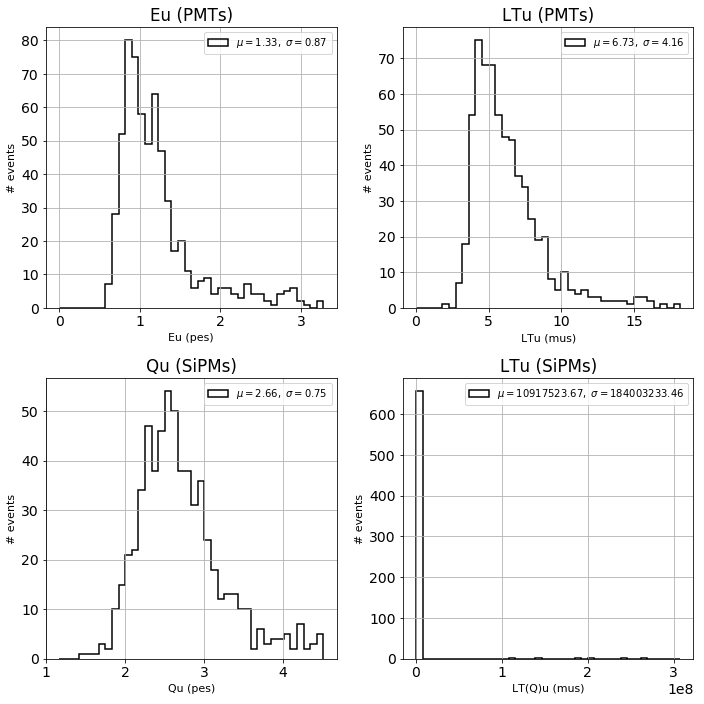

In [134]:
krh.h1d_4(h1ds    = (Escale.uncertainty[Eok].flatten(), ELT.uncertainty[Eok].flatten(), 
                     Qscale.uncertainty[Eok].flatten(), QLT.uncertainty[Eok].flatten()),
      bins    = (40, 40, 40, 40),
      ranges  = ((Eu_min, Eu_max), (ELTu_min, ELTu_max),(Qu_min, Qu_max), (QLTu_min, QLTu_max) ),
      xlabels = ('Eu (pes)', 'LTu (mus)', 'Qu (pes)', 'LT(Q)u (mus)'),
      ylabels = ('# events', '# events', '# events', '# events'),
      titles  = ('Eu (PMTs)', 'LTu (PMTs)', 'Qu (SiPMs)', 'LTu (SiPMs)'),
      legends = ('best','best','best','best'),
      figsize =(10,10))

Average lifetime             (mean +- rms) = ((15.8 +- 2.9) · 1e2) µs
Average lifetime uncertainty (mean +- rms) = (5.4 +- 1.6) (%)


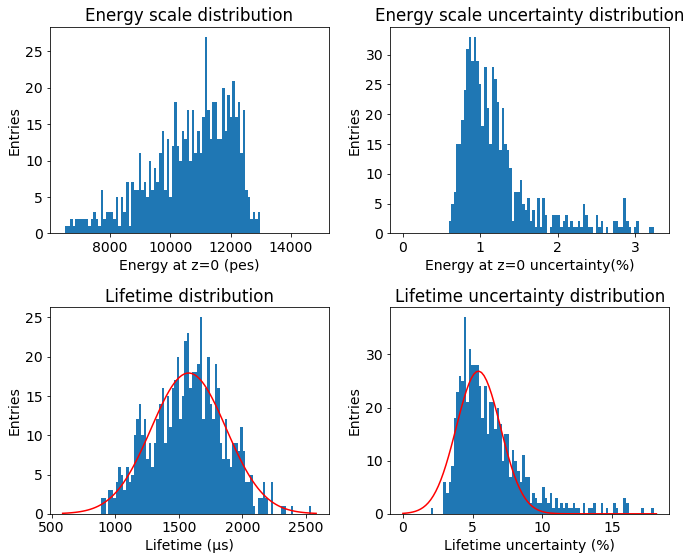

In [135]:
plt.subplot(2, 2, 1)
bins    = np.linspace(E_min, E_max, 101)
y, x, _ = plt.hist(Escale.value[Eok].flatten(), bins)
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Eu_min, Eu_max, 101)
y, x, _ = plt.hist(Escale.uncertainty[Eok].flatten(), bins)
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(ELT_min, ELT_max, 101)
y, x, _ = plt.hist       (ELT.value[Eok].flatten(), bins)
f       = quick_gauss_fit(ELT.value[Eok].flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(ELTu_min, ELTu_max, 101)
y, x, _ = plt.hist       (ELT.uncertainty[Eok].flatten(), bins)
fu      = quick_gauss_fit(ELT.uncertainty[Eok].flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

plt.tight_layout()


print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


AssertionError: 

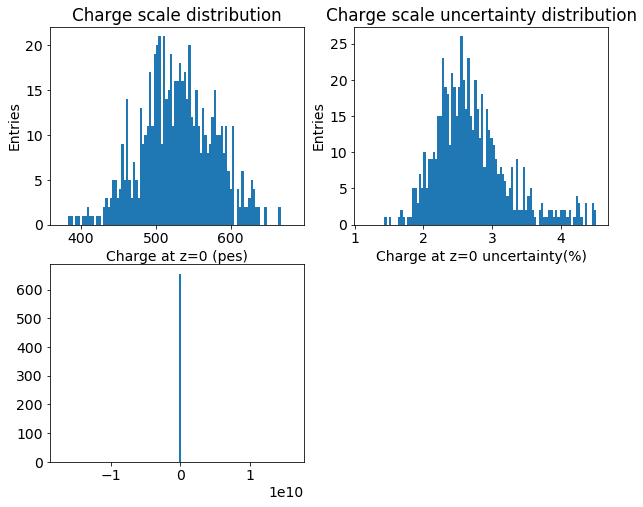

In [136]:
plt.subplot(2, 2, 1)
bins    = np.linspace(Q_min, Q_max, 101)
y, x, _ = plt.hist(Qscale.value[Eok].flatten(), bins)
labels("Charge at z=0 (pes)", "Entries", "Charge scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Qu_min, Qu_max, 101)
y, x, _ = plt.hist(Qscale.uncertainty[Eok].flatten(), bins)
labels("Charge at z=0 uncertainty(%)", "Entries", "Charge scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(QLT_min, QLT_max, 101)
y, x, _ = plt.hist       (QLT.value[Eok].flatten(), bins)
f       = quick_gauss_fit(QLT.value[Eok].flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Charge lifetime (µs)", "Entries", "Charge lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(QLTu_min, QLTu_max, 101)
y, x, _ = plt.hist       (QLT.uncertainty[Eok].flatten(), bins)
fu      = quick_gauss_fit(QLT.uncertainty[Eok].flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Charge lifetime uncertainty (%)", "Entries", "Charge lifetime uncertainty distribution")

plt.tight_layout()


print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

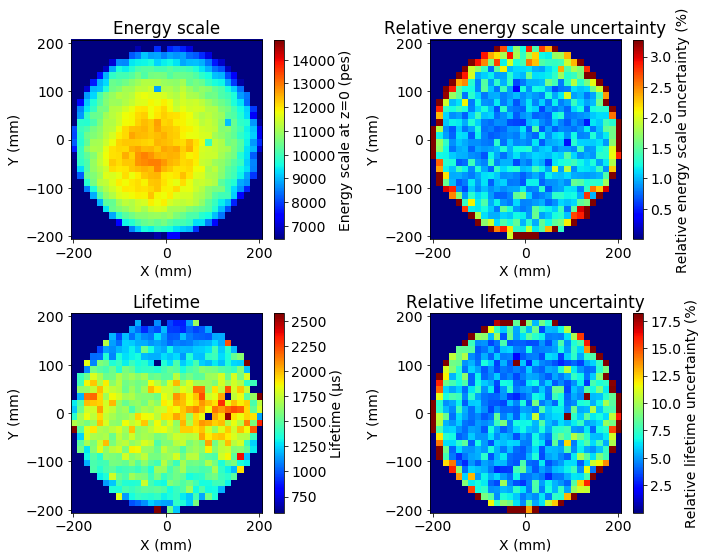

In [138]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.value,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.uncertainty,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, ELT.value,
                        vmin = ELT_min,
                        vmax = ELT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, ELT.uncertainty,
                        vmin = ELTu_min,
                        vmax = ELTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()


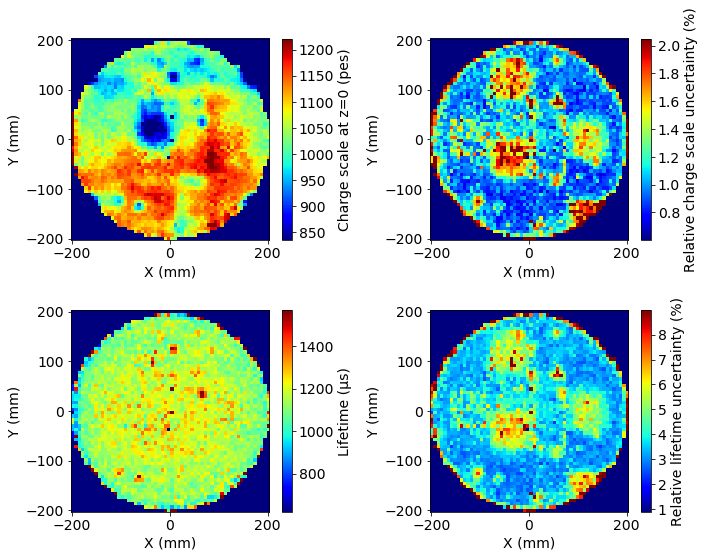

In [31]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.value,
                        vmin = Q_min,
                        vmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Charge scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Charge scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale.uncertainty,
                        vmin = Qu_min,
                        vmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative charge scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative charge scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, QLT.value,
                        vmin = QLT_min,
                        vmax = QLT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, QLT.uncertainty,
                        vmin = QLTu_min,
                        vmax = QLTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_charge_scale_maps")

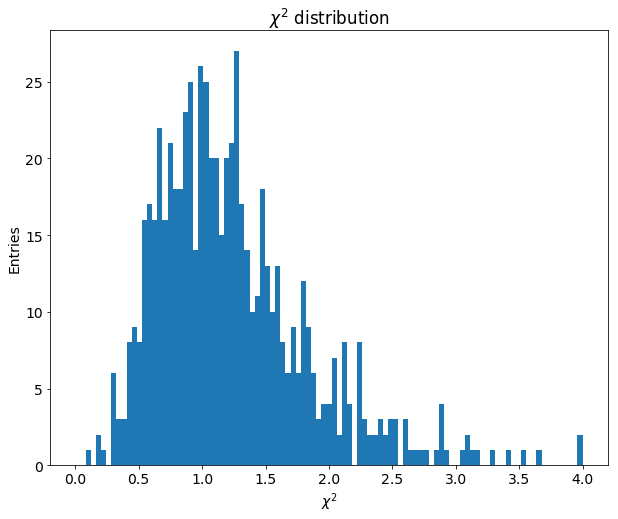

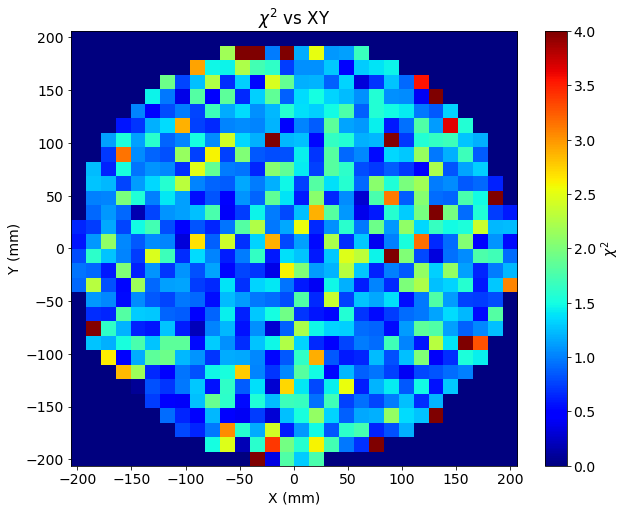

In [139]:
plt.hist(Echi2[Echi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Echi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

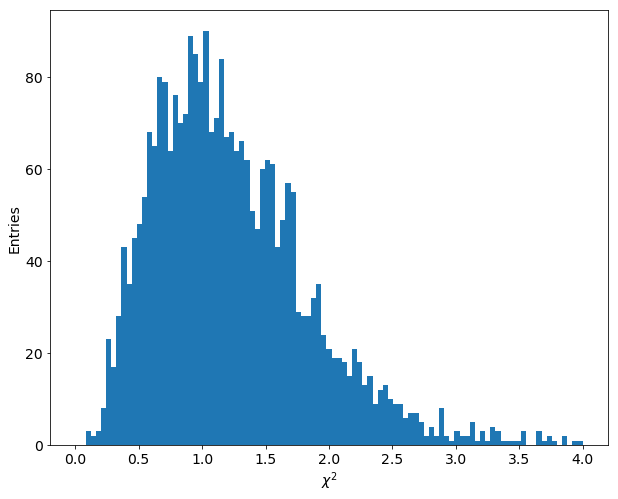

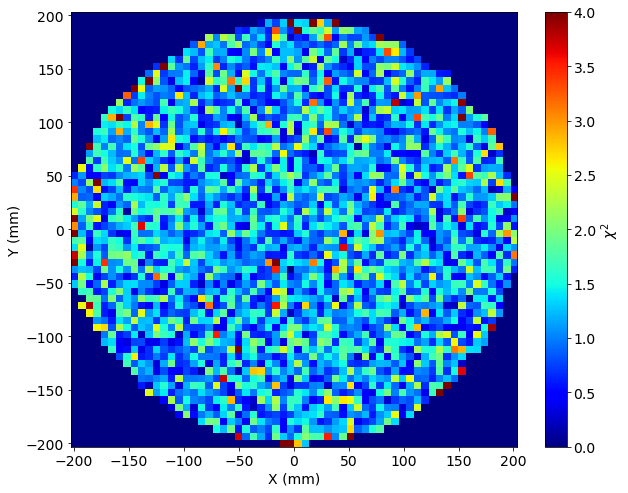

In [33]:
plt.hist(Qchi2[Qchi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Qchi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [34]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(Eok, Escale_abs.value      ,     E_mean)
Escaleu_safe = np.where(Eok, Escale_abs.uncertainty,    Eu_mean *   E_mean / 100)

ELT_safe     = np.where(Eok,   ELT_abs.value      , ELT_mean)
ELTu_safe    = np.where(Eok,ELT_abs.uncertainty,    ELTu_mean * ELT_mean / 100)

Qscale_safe  = np.where(Qok, Qscale_abs.value      ,     Q_mean)
Qscaleu_safe = np.where(Qok, Qscale_abs.uncertainty,    Qu_mean *   Q_mean / 100)

QLT_safe     = np.where(Qok,   QLT_abs.value      ,  QLT_mean)
QLTu_safe    = np.where(Qok,   QLT_abs.uncertainty, QLTu_mean * QLT_mean / 100)

with tb.open_file(correction_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_safe, ELTu_safe, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch

    write_qscale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Qscale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Qscale_safe, Qscaleu_safe, nevt)
    correction_file.root.XYcorrections.Qscale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Qscale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "QLifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, QLT_safe, QLTu_safe, nevt)
    correction_file.root.XYcorrections.QLifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.QLifetime.attrs.xy_pitch = XYpitch